In [ ]:
# python
import sys
import os
import importlib
# columnar analysis
import awkward as ak
from dask.distributed import Client
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities, cutflow, scaleout
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
bg_samples = [
    "TTJets",
]

#######################################################
SIDM_4mu_100GeV_0p25GeV_samples = [
    "4mu_100GeV_0p25GeV_0p02mm",
    "4mu_100GeV_0p25GeV_0p2mm",
    "4mu_100GeV_0p25GeV_2p0mm",
    "4mu_100GeV_0p25GeV_10p0mm",
    "4mu_100GeV_0p25GeV_20p0mm",
]
SIDM_4mu_100GeV_1p2GeV_samples = [
    "4mu_100GeV_1p2GeV_0p096mm",
    "4mu_100GeV_1p2GeV_0p96mm",
    "4mu_100GeV_1p2GeV_9p6mm",
    "4mu_100GeV_1p2GeV_48p0mm",
    "4mu_100GeV_1p2GeV_96p0mm",
]
SIDM_4mu_100GeV_5p0GeV_samples = [
    "4mu_100GeV_5p0GeV_0p4mm",
    "4mu_100GeV_5p0GeV_4p0mm",
    "4mu_100GeV_5p0GeV_40p0mm", 
    "4mu_100GeV_5p0GeV_200p0mm",
    "4mu_100GeV_5p0GeV_400p0mm",
]
#######################################################
SIDM_4mu_150GeV_0p25GeV_samples = [
    "4mu_150GeV_0p25GeV_0p013mm",
    "4mu_150GeV_0p25GeV_0p13mm",
    "4mu_150GeV_0p25GeV_1p3mm",
    "4mu_150GeV_0p25GeV_6p7mm",
    "4mu_150GeV_0p25GeV_13p0mm",
]
SIDM_4mu_150GeV_1p2GeV_samples = [
    "4mu_150GeV_1p2GeV_0p064mm",
    "4mu_150GeV_1p2GeV_0p64mm",
    "4mu_150GeV_1p2GeV_6p4mm",
    "4mu_150GeV_1p2GeV_32p0mm",
    "4mu_150GeV_1p2GeV_64p0mm",
]
SIDM_4mu_150GeV_5p0GeV_samples = [
    "4mu_150GeV_5p0GeV_0p27mm",
    "4mu_150GeV_5p0GeV_2p7mm",
    "4mu_150GeV_5p0GeV_27p0mm",
    "4mu_150GeV_5p0GeV_130p0mm",
    "4mu_150GeV_5p0GeV_270p0mm",
]
#######################################################
SIDM_4mu_200GeV_0p25GeV_samples = [
    "4mu_200GeV_0p25GeV_0p01mm",
    "4mu_200GeV_0p25GeV_0p1mm",
    "4mu_200GeV_0p25GeV_1p0mm",
    "4mu_200GeV_0p25GeV_5p0mm",
    "4mu_200GeV_0p25GeV_10p0mm",
]
SIDM_4mu_200GeV_1p2GeV_samples = [
    "4mu_200GeV_1p2GeV_0p048mm",
    "4mu_200GeV_1p2GeV_0p48mm",
    "4mu_200GeV_1p2GeV_4p8mm",
    "4mu_200GeV_1p2GeV_24p0mm",
    "4mu_200GeV_1p2GeV_48p0mm",
]
SIDM_4mu_200GeV_5p0GeV_samples = [
    "4mu_200GeV_5p0GeV_0p2mm",
    "4mu_200GeV_5p0GeV_2p0mm",
    "4mu_200GeV_5p0GeV_20p0mm",
    "4mu_200GeV_5p0GeV_100p0mm",
    "4mu_200GeV_5p0GeV_200p0mm",
]
#######################################################
SIDM_4mu_500GeV_0p25GeV_samples = [
    "4mu_500GeV_0p25GeV_0p004mm",
    "4mu_500GeV_0p25GeV_0p04mm",
    "4mu_500GeV_0p25GeV_0p4mm",
    "4mu_500GeV_0p25GeV_2p0mm",
    "4mu_500GeV_0p25GeV_4p0mm",
]
SIDM_4mu_500GeV_1p2GeV_samples = [
    "4mu_500GeV_1p2GeV_0p019mm",
    "4mu_500GeV_1p2GeV_0p19mm",
    "4mu_500GeV_1p2GeV_1p9mm",
    "4mu_500GeV_1p2GeV_9p6mm",
    "4mu_500GeV_1p2GeV_19p0mm",
]
SIDM_4mu_500GeV_5p0GeV_samples = [
    "4mu_500GeV_5p0GeV_0p08mm",
    "4mu_500GeV_5p0GeV_0p8mm",
    "4mu_500GeV_5p0GeV_8p0mm",
    "4mu_500GeV_5p0GeV_40p0mm",
    "4mu_500GeV_5p0GeV_80p0mm",
    
    #"4mu_500GeV_5p0GeV_800p0mm",
    #"4mu_500GeV_5p0GeV_8000p0mm", these are also here as long Lxy tests
]
#######################################################
SIDM_4mu_800GeV_0p25GeV_samples = [
    "4mu_800GeV_0p25GeV_0p0025mm",
    "4mu_800GeV_0p25GeV_0p025mm",
    "4mu_800GeV_0p25GeV_0p25mm",
    "4mu_800GeV_0p25GeV_1p2mm",
    "4mu_800GeV_0p25GeV_2p5mm",
]
SIDM_4mu_800GeV_1p2GeV_samples = [
    "4mu_800GeV_1p2GeV_0p012mm",
    "4mu_800GeV_1p2GeV_0p12mm",
    "4mu_800GeV_1p2GeV_1p2mm",
    "4mu_800GeV_1p2GeV_6p0mm",
    "4mu_800GeV_1p2GeV_12p0mm",
]
SIDM_4mu_800GeV_5p0GeV_samples = [
    "4mu_800GeV_5p0GeV_0p05mm",
    "4mu_800GeV_5p0GeV_0p5mm",
    "4mu_800GeV_5p0GeV_5p0mm",
    "4mu_800GeV_5p0GeV_25p0mm",
    "4mu_800GeV_5p0GeV_50p0mm",
]
#######################################################
SIDM_4mu_1000GeV_0p25GeV_samples = [ # getting keyErrors on all of these; I think they might be empty
    "4mu_1000GeV_0p25GeV_0p002mm", # Running gives "cannot unpack non-iterable NoneType object"
    "4mu_1000GeV_0p25GeV_0p02mm",
    "4mu_1000GeV_0p25GeV_0p2mm",
    "4mu_1000GeV_0p25GeV_1p0mm",
    "4mu_1000GeV_0p25GeV_2p0mm",
]
SIDM_4mu_1000GeV_1p2GeV_samples = [ # these also give keyErrors
    "4mu_1000GeV_1p2GeV_0p0096mm",
    "4mu_1000GeV_1p2GeV_0p096mm",
    "4mu_1000GeV_1p2GeV_0p96mm",
    "4mu_1000GeV_1p2GeV_4p8mm",
    "4mu_1000GeV_1p2GeV_9p6mm",
]
SIDM_4mu_1000GeV_5p0GeV_samples = [
    "4mu_1000GeV_5p0GeV_0p04mm",
    "4mu_1000GeV_5p0GeV_0p4mm",
    "4mu_1000GeV_5p0GeV_4p0mm",
    "4mu_1000GeV_5p0GeV_20p0mm",
    "4mu_1000GeV_5p0GeV_40p0mm",
]
#######################################################


SIDM_4mu_100GeV_samples = []
SIDM_4mu_100GeV_samples = SIDM_4mu_100GeV_samples + SIDM_4mu_100GeV_0p25GeV_samples + SIDM_4mu_100GeV_1p2GeV_samples + SIDM_4mu_100GeV_5p0GeV_samples

SIDM_4mu_150GeV_samples = []
SIDM_4mu_150GeV_samples = SIDM_4mu_150GeV_samples + SIDM_4mu_150GeV_0p25GeV_samples + SIDM_4mu_150GeV_1p2GeV_samples + SIDM_4mu_150GeV_5p0GeV_samples

SIDM_4mu_200GeV_samples = []
SIDM_4mu_200GeV_samples = SIDM_4mu_200GeV_samples + SIDM_4mu_200GeV_0p25GeV_samples + SIDM_4mu_200GeV_1p2GeV_samples + SIDM_4mu_200GeV_5p0GeV_samples

SIDM_4mu_500GeV_samples = []
SIDM_4mu_500GeV_samples = SIDM_4mu_500GeV_samples + SIDM_4mu_500GeV_0p25GeV_samples + SIDM_4mu_500GeV_1p2GeV_samples + SIDM_4mu_500GeV_5p0GeV_samples

SIDM_4mu_800GeV_samples = []
SIDM_4mu_800GeV_samples = SIDM_4mu_800GeV_samples + SIDM_4mu_800GeV_0p25GeV_samples + SIDM_4mu_800GeV_1p2GeV_samples + SIDM_4mu_800GeV_5p0GeV_samples

SIDM_4mu_1000GeV_samples = []
SIDM_4mu_1000GeV_samples = SIDM_4mu_1000GeV_samples + SIDM_4mu_1000GeV_0p25GeV_samples + SIDM_4mu_1000GeV_1p2GeV_samples + SIDM_4mu_1000GeV_5p0GeV_samples

samples_sublists = [
    #SIDM_4mu_100GeV_0p25GeV_samples, SIDM_4mu_100GeV_1p2GeV_samples, SIDM_4mu_100GeV_5p0GeV_samples, 
    #SIDM_4mu_150GeV_0p25GeV_samples, SIDM_4mu_150GeV_1p2GeV_samples, SIDM_4mu_150GeV_5p0GeV_samples,
    #SIDM_4mu_200GeV_0p25GeV_samples, SIDM_4mu_200GeV_1p2GeV_samples, SIDM_4mu_200GeV_5p0GeV_samples, 
    #SIDM_4mu_500GeV_0p25GeV_samples, SIDM_4mu_500GeV_1p2GeV_samples, SIDM_4mu_500GeV_5p0GeV_samples,
    SIDM_4mu_800GeV_0p25GeV_samples, SIDM_4mu_800GeV_1p2GeV_samples, SIDM_4mu_800GeV_5p0GeV_samples,
    #SIDM_4mu_1000GeV_0p25GeV_samples, 
    #SIDM_4mu_1000GeV_1p2GeV_samples, # These two groups don't work at all
    #SIDM_4mu_1000GeV_5p0GeV_samples,
    ]

In [3]:
#fname = '~/local_data/tta_mAlp-0p35GeV_ctau-1e3mm_part-0.root'
samples = [   
    #"4mu_500GeV_5GeV_0p08mm", # testing v1
    #"4mu_500GeV_5GeV_0p08mm", # testing v2
]
#samples = samples + bg_samples
for sublist in samples_sublists:
    samples = samples + sublist

merged_samples = [
    "4mu_500GeV_5GeV_0p08mm",
    "4mu_500GeV_5GeV_0p8mm",
    "4mu_500GeV_5GeV_8p0mm",
    "4mu_500GeV_5GeV_40p0mm",
    "4mu_500GeV_5GeV_80p0mm"
]

fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=1)
#fileset = utilities.make_fileset(merged_samples, "llpNanoAOD_v2_merged")

# create events collection from single file
fname = fileset[samples[0]][0]
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
).events()

In [4]:
fnames = [fileset[sample] for sample in samples]
#for name in fnames:
    #print(name[0])

In [14]:
#print(events.DSAMuon.muonMatch1[0])
#print(set(ak.flatten(events.DSAMuon.muonMatch1idx)))
#print(events.DSAMuon[0])
#print(events.Muon[0])
#print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])
a = ak.Array([[0, 1, 0], [1]])
b = ak.Array([[71, 72], [59, 58, 57]])
b[a]

{0.0, 1.0, 2.0, 3.0, 4.0}
[{idx: 0, pt: 60.7, ptErr: 14.5, eta: 1.85, ... nDTSegments: 0, nCSCSegments: 4}]
[Muon, Muon, Muon, Muon, Muon]


<Array [[71, 72, 71], [58]] type='2 * var * int64'>

In [15]:
#print(events.DSAMuon.muonMatch1)
#print(events.DSAMuon.muonMatch1idx)
#print(ak.flatten(events.DSAMuon.muonMatch1idx))
#print(events.DSAMuon.outerPhi)
#print(events.Muon.outerPhi)
#print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")].outerPhi)
#utilities.dR_outer(events.DSAMuon, events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])

[[4, 4, 0, 4, 0], [3, 3, 3, 4, 0], [4, 3, ... 4, 3, 3], [2, 4, 4, 4], [4, 3, 4, 3]]
[[1.72, 1.59, 1.76, 1.63, 0.0259], [-2.76, ... -2.2], [-2.9, 2.83, 2.79, -2.96]]


In [16]:
#from coffea.nanoevents.schemas.base import zip_forms
from coffea.nanoevents.methods import vector as cvec
from coffea.nanoevents.methods import nanoaod
#print(events.Muon)
#print([events.DSAMuon[x] for x in ["pt", "eta"]])
print(events.DSAMuon)
forms = {f : events.DSAMuon[f] for f in events.DSAMuon.fields}
events.DSAMuon = ak.zip(forms, with_name="Muon", behavior=nanoaod.behavior)
#print(events.DSAMuon)
#print(events.DSAMuon.nearest(events.Muon))

[[{idx: 0, pt: 60.7, ptErr: 14.5, eta: 1.85, ... nDTSegments: 0, nCSCSegments: 3}]]


In [17]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    #executor=processor.DaskExecutor(),
    executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    # maxchunks=1,
)

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
hist_choice = "base"
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections
p = sidm_processor.SidmProcessor(
    [
        "baseNoLj",
        "llpnano",
        "llpnano_4mu",
        "llpnano_3lj",
        "matchedLj"
        #"4mu",
        #"4mutest",
        #"barrelE_ID-DPhiIn",
    ],
    [hist_choice],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

Output()

Not applying any cuts to the lepton jets for channel baseNoLj


/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Not applying any cuts to the lepton jets for channel baseNoLj
Not apply

Issues with running llpNanoAODs:
1. Seems like some of the v2 ntuple files don't work

None of them can run channels 2mu2e or 4mu. --- I was able to make it work by adding an object-level cut on the muons (pT > 5 GeV). Not sure why this affected anything.

In [18]:
#Add ttbar
keys = list(output['out']["TTJets"]["hists"].keys())[:]
TT_Hists = {k: output['out']["TTJets"]["hists"][k] for k in keys}

keys = list(output['out']["TTJets"]["cutflow"].keys())[:]
TT_Cutflow = {k: output['out']["TTJets"]["cutflow"][k] for k in keys}

KeyError: 'TTJets'

In [ ]:
#This defines a function to break down the samples and make individual subplots for each one.
#Fix: should set the specific range as a parameter. For now, it uses [ :1200j]. Could be an issue in the future.
def plotSamples(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(samples)
    nhists = len(hists)
    if (nplots <= 6): ncol, nrow = nplots, 1
    else: ncol, nrow = 6, (nplots-1)//6 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
    Tot_BG_Flag = not fullBg
    for i in range(nplots):
        plt.subplot(nrow, ncol, i+1)
        j = 0
        if "DY_Jets" in samples and DY_Flag == False:
            for j in range(nhists):
                utilities.plot(DY_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
        elif "QCD_Jets" in samples and QCD_Flag == False:
            for j in range(nhists):
                utilities.plot(QCD_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
        elif "DiBoson_Jets" in samples and DB_Flag == False:
            for j in range(nhists):
                utilities.plot(DiBoson_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
        elif "TTJets" in samples and TT_Flag == False:
            for j in range(nhists):
                utilities.plot(TT_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
        elif "Total Background" in samples and Tot_BG_Flag == False:
            for j in range(nhists):
                utilities.plot(bg_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
        else:
            for j in range(nhists):
                utilities.plot(out[samples[i]]["hists"][hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
        plt.legend(hists)
        plt.title(samples[i])

In [ ]:
#This function plots each histogram on a separate subplot, showing all samples on each subplot
def plotHists(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(hists)
    if (nplots <= 5): ncol, nrow = nplots, 1
    else: ncol, nrow = 4, (nplots-1)//4 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    for i in range(nplots):
        DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
        plt.subplot(nrow, ncol, i+1)
        j = 0
        while j < len(samples):
            if "DY_Jets" in samples and DY_Flag == False:
                utilities.plot(DY_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
            elif "QCD_Jets" in samples and QCD_Flag == False:
                utilities.plot(QCD_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
            elif "DiBoson_Jets" in samples and DB_Flag == False:
                utilities.plot(DiBoson_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
            elif "TTJets" in samples and TT_Flag == False:
                utilities.plot(TT_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
            elif "Total Background" in samples and Tot_BG_Flag == False:
                utilities.plot(bg_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
            else:
                utilities.plot(out[samples[j]]["hists"][hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
            j = j + 1
        plt.legend(samples, prop={'size': 11})
        plt.title(hists[i])

In [14]:
#g = events.GenPart
#print(g)
#print(ak.count(g))
#print(ak.num(g, axis=1))
#print(ak.num(g, axis=0))
#print(ak.num(g.children, axis=2))
#g = g[ak.num(g.children, axis=2) > 0]
#print(g.children[ak.num(g.children, axis=2) > 0][:, :, 0])
#print(ak.count(ak.num(g.children, axis=2) > 0))
#print(g.children[:, :, 0])
#print((g - g.children[:, :, 0]))
#print(ak.num(g.children))
#print(ak.firsts(g.children))
#print(ak.num(ak.firsts(g.children)))
#print(~ak.is_none(ak.firsts(g.children)))
#print((g - g.children[:, :, 0]).r)
#print(g.pdgId)
#zd = g[g.pdgId == 32]
#ak.num(zd.children)
#print(zd)
#zd_lxy = (zd - ak.firsts(zd.children)).r
#print(zd_lxy)
#print(ak.num(zd_lxy, axis=1))
zd = events.GenPart[abs(events.GenPart.pdgId) == 32]
print(zd)
print(ak.num(zd))

[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
fraction = False

for sublist in samples_sublists:
    cutflows = [out["TTJets"]["cutflow"]["matchedLj"]]
    headers = ["TTJets"]
    delimiter = '.'
    for sample in sublist:
        cutflows.append(out[sample]["cutflow"]["matchedLj"])
        if '_' in sample:
            headers.append(sample.split('_')[1] + delimiter + sample.split('_')[2] + delimiter + sample.split('_')[-1])
        else:
            headers.append(sample)
    title = "Basic cuts - fractional" if fraction else "Basic cuts"
    title = title + ' for ' + sublist[0].split('_')[1] + ' mass bound state and ' + sublist[0].split("_")[2] + ' mass dark photon'
    cutflow.print_multi_table(cutflows, headers, fraction, False, title)

In [ ]:
histlist = ["pv_n", "pv_ndof", "pv_z"]
#plotSamples(histlist, "llpnano", False, True)

In [ ]:
histlist = []
samples_used = [sample for sample in samples[1:2]]
for hist in collection: 
    if "phi" in hist:
        histlist.append(hist)
histlist.remove("abcd_lj_lj_dphi_vs_lj0_pfIsolationPt05")
#histlist = histlist[:-9] 
print(histlist)
plt.subplots(2, 3, figsize=(30,18))
for i in range(len(histlist[:-1])):
    plt.subplot(2,3,i+1)
    if "eta_phi" in histlist[i]:
        for sample in samples_used:
            utilities.plot(out[sample]["hists"][histlist[i]]["llpnano", :, :], flow='none')
    else:
        for sample in samples_used:
            utilities.plot(out[sample]["hists"][histlist[i]]["llpnano", :], density=True, yerr=False, flow='none')
    plt.title(histlist[i])
    plt.legend(samples_used)

In [ ]:

#histlist = []
#for hist in collection: 
#    if "eta_phi" not in hist:
#        histlist.append(hist)

#histlist.remove("abcd_lj_lj_dphi_vs_lj0_pfIsolationPt05") #All removed histrograms returned a "wrong number of indices" error
#histlist = histlist[:-9] 
# The last 9 histograms were empty, and each histogram plotted on each axis returned a warning (with ~30 samples & 9 histograms, this is ~270 times)
# Warnings for each hist were "cannot compute error bars" "invalid value in *= scale" "divide by zero encountered", comes to ~750 error messages
#plotHists(histlist, "llpnano_4mu", False, True)

In [ ]:
#samples_used = [sample for sample in samples[1:]]
samples_used = [sample for sample in samples]

ymax1 = ymax2 = 0
ymin1 = ymin2 = 10000000000
for sample in samples_used:
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0] > ymax1:
        ymax1 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0]
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1] < ymin1:
        ymin1 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1]
        
for sample in samples_used[1:]:
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0] > ymax2:
        ymax2 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0]
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1] < ymin2:
        ymin2 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1]
        
ylimits1 = [ymin1*0.9, ymax1*1.1]
ylimits2 = [ymin2*0.9, ymax2*1.1]
 ############## Parameters ################
giveFraction = True
log = False
legend = False
 ##########################################
if giveFraction:
    ylimits1 = [0.1,110]
    ylimits2 = [0.1,110]
    if log:
        ylimits1 = [0.1,120]
        ylimits2 = [10,120]

plt.subplots(2,2,figsize=(24,18))

plt.subplot(2,2,1)
temp = [out[sample]["cutflow"]["llpnano"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["llpnano"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits1)
plt.xticks(rotation=20)

plt.subplot(2,2,2)
temp = [out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["llpnano_4mu"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits1)
plt.xticks(rotation=20)


plt.subplot(2,2,3)
temp = [out[sample]["cutflow"]["llpnano_3lj"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["llpnano_3lj"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("SIDM Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits2)
plt.xticks(rotation=20)

plt.subplot(2,2,4)
temp = [out[sample]["cutflow"]["matchedLj"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["matchedLj"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("SIDM Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits2)
plt.xticks(rotation=20)

Judging by this, the cutflow (which is similar to the 4mu set) doesn't significantly impact the samples, but cuts the background TTbar by about 2 orders of magnitude. However, unlike the ffntuples, this TTbar set is much more significant after the cuts, keeping 33 percent instead of being cut down to zero. Applying the 4mu cut brings the background level to about 3 percent, which is still higher than that found in the ffntuples.

I've added a second channel, llpnano_4mu, to try to alleviate this. While some of the cuts impact the SIDM samples (especially a requirement that there be >=4 muons in each event), they drastically reduce the remaining background down to about 0.25%. The purple line above (which is removed from the second row) shows the change in TTbar events through the cutflow. The second row is a zoomed in look at the SIDM samples throughout.

After adding several more samples, the >=4 muon requirement is a clear issue. While the TTbar fraction falls below 0.25%, some SIDM samples have below 20% efficiency with this cut. It has been changed to a >=3 muon cut.

This change makes the SIDM lowest efficency 48 percent, with the most "damaging" cut still the >=3 muons. It is also now removed and replaced with a >=2 muon cut. After this, all the SIDM samples had efficiencies of above 60%, which is very close to that left after the >=2 lepton jet cut. At this point, the muon requirement is no longer a serious issue for efficiency, but removes a great deal of background, leaving 2% efficiency for TTbar.

Another possible cut is placing a limit on the quantity lj_lj_invmass to be greater than 100 GeV. Nearly all SIDM events are generated with larger invariant mass (as the smallest samples have a 100 GeV bound state), while the background extends well below. A cut at 200 GeV would remove nearly all of the background, at the cost of losing the lighter SIDM samples.

Next Steps:
Continue plotting ljs, start finding attributes of the lepton jet contents (e.g. muons, photons, electrons in the jets). Try defining the attributes for histograms that do not plot.

In [ ]:
utilities.plot([out["TTJets"]["hists"]["lj_lj_invmass_lowRange"]["llpnano", :], out[samples[2]]["hists"]["lj_lj_invmass_lowRange"]["llpnano", :]], density=True)
plt.legend(["TTJets", samples[2]])
#plt.xlim([0,100])

The next section replicates some of the plots used in the ffntuple background analysis. These include the number of lepton jets found, the invariant mass of the lepton jets, the magnitude of the delta-phi in the lepton jets, and a measure of the isolation of the jets. The plots differ from the SIDM samples in the ffntuple sets in several meaningful ways. Most obviously, the isolation plot does not generate. This may be due to isolation being calculated differently, and may be an important fix to make to the processor when it generates histograms.

Second, there is a large peak of several samples with low |deltaPhi|. These are not background, and are searched for below this. These peaks are made up exclusively of the most collimated samples from the 800 and 500 GeV mass bound states. The lower-mass bound states also have a noticable shift towards lower dPhi values. I don't know why these have such a large offset and all other samples are clustered around 3.14.

Third, there are noticably more lepton jets found in these samples. The lj_n histogram have a maximum of 5 lepton jets per event, while the ffntuple version of this plot only has 0-2, with a very small number of events having three lepton jets. This may indicate a bias in the geration of the ffntuples, where they are restricted to contain only the SIDM process, without other lepton jets present.

(This code does not attempt to plot the isolation histogram, since it produces several error messages per sample, coming out to hundreds of lines of messages. Regardless, the axes were empty when the plot was attempted.)

The increase in lepton_jet_n and the low deltaPhi might both be due to issues with the clustering algorithm; if one lepton jet is incorrectly identified as two, they would appear close to each other as well as appearing to have more jets. However, applying the new llpnano_3lj cut, which removes any events with 4 or more lepton jets, does not change the profiles of the histograms at all (besides, of course, the lj_n one).

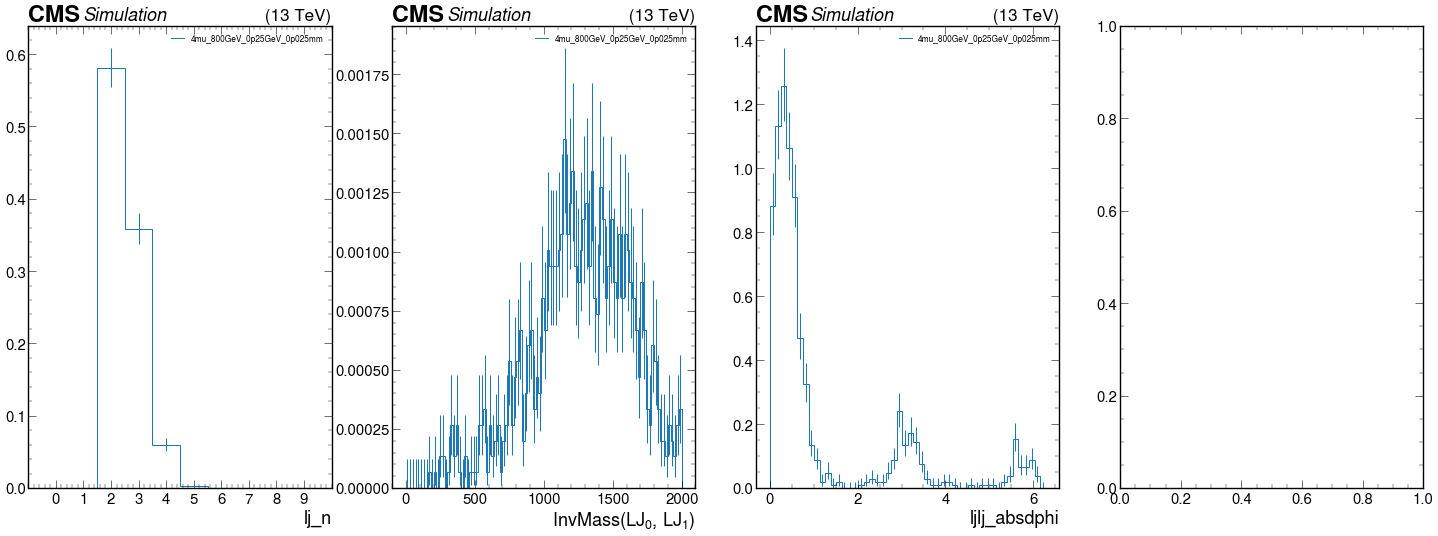

In [21]:
samples_used = [sample for sample in samples[1:2]]
#samples_used.append("TTJets")
hists_used = ["lj_n", "lj_lj_invmass", "lj_lj_absdphi"]#"lj_pfIsolation07"]
plt.subplots(1,4,figsize=(36,12))
for i in range(len(hists_used)):
    plt.subplot(1,4,i+1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 12}, ncol=2)
    
#plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "baseNoLj", True, True, samples_used)

In [ ]:
samples_used = [sample for sample in samples[60:65]]
#samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,2,figsize=(30,16))
plt.subplot(1,2,1)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano", :], density=False, flow='none')
plt.legend(samples_used, prop={'size': 16}, ncol=2)
plt.title("Base Cuts")
plt.subplot(1,2,2)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_3lj", :], density=False, flow='none')
plt.legend(samples_used, prop={'size': 16}, ncol=2)
plt.title("Base Cuts + <= 3 LJs")

In [ ]:
samples_used = [sample for sample in samples[45:49]]
#samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,2,figsize=(30,16))
plt.subplot(1,2,1)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 16}, ncol=2)
plt.subplot(1,2,2)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_3lj", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 16}, ncol=2)

In [ ]:
samples_remove = [sample for sample in samples[59:64]]
samples_used = [sample for sample in samples[45:49]]

#for sample in samples_remove:
#    samples_used.remove(sample)
#samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,1,figsize=(16,16))
for i in range(len(hists_used)):
    plt.subplot(1,1,1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 18}, ncol=2, loc=1)

In [ ]:
samples_remove = [sample for sample in samples[59:64]]
samples_remove2 = [sample for sample in samples[45:49]]
samples_used = [sample for sample in samples[1:]]

for sample in samples_remove:
    samples_used.remove(sample)
for sample in samples_remove2:
    samples_used.remove(sample)
    
samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,2,figsize=(30,12))
plt.subplot(1,2,1)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_4mu", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)
plt.title("Density Plot")
plt.subplot(1,2,2)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_4mu", :], density=False, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)   
plt.title("Weighted Events")

In [ ]:
samples_remove = [sample for sample in samples[59:64]]
samples_remove2 = [sample for sample in samples[45:49]]
samples_used = [sample for sample in samples[1:]]

for sample in samples_remove:
    samples_used.remove(sample)
for sample in samples_remove2:
    samples_used.remove(sample)
    
samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,2,figsize=(30,12))
plt.subplot(1,2,1)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_4mu", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)
plt.title("Density Plot")
plt.subplot(1,2,2)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_4mu", :], density=False, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)   
plt.title("Weighted Events")

In [ ]:
samples_remove = [sample for sample in samples[59:64]]
samples_remove2 = [sample for sample in samples[45:49]]
samples_used = [sample for sample in samples[1:]]

for sample in samples_remove:
    samples_used.remove(sample)
for sample in samples_remove2:
    samples_used.remove(sample)
    
samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,2,figsize=(30,12))
plt.subplot(1,2,1)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)
plt.title("llpnano channel")
plt.subplot(1,2,2)
for sample in samples_used:
    utilities.plot(out[sample]["hists"][hists_used[0]]["llpnano_4mu", :], density=True, flow='none')
plt.legend(samples_used, prop={'size': 6}, ncol=2)   
plt.title("llpnano_4mu channel")
print(out[samples_used[0]]["cutflow"]["llpnano"].cut_breakdown(giveCuts=True))
print(out[samples_used[0]]["cutflow"]["llpnano_4mu"].cut_breakdown(giveCuts=True))

In [ ]:
n=15
samples_used = [sample for sample in samples[n:n+5]]

samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,1,figsize=(14,14))
for i in range(len(hists_used)):
    plt.subplot(1,1,1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 12}, ncol=2)

In [ ]:
n=30
samples_used = [sample for sample in samples[n:n+4]]

samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,1,figsize=(14,14))
for i in range(len(hists_used)):
    plt.subplot(1,1,1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 12}, ncol=2, loc=1)

In [ ]:
samples_used = [sample for sample in samples if "0p25GeV" not in sample] # removing all 0.25 GeV Zd removes the peak near 0.
hists_used = ["lj_lj_absdphi"]
plt.subplots(1,1,figsize=(20,16))
for i in range(len(hists_used)):
    plt.subplot(1,1,1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 8}, ncol=2)

In [ ]:
samples_used_0p25 = [sample for sample in samples if "0p25GeV" in sample]
samples_used_1p2 = [sample for sample in samples if "1p2GeV" in sample] 
samples_used_5p0 = [sample for sample in samples if "5p0GeV" in sample] 

hists_used = ["lj_lj_absdphi"]
plt.subplots(1,3,figsize=(32,16))
for i in range(len(hists_used)):
    plt.subplot(1,3,1)
    for sample in samples_used_0p25:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used_0p25, prop={'size': 11}, ncol=2, loc=1)
    plt.title("0p25GeV_Zd", fontsize = 20)
    plt.subplot(1,3,2)
    for sample in samples_used_1p2:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used_1p2, prop={'size': 12}, ncol=2, loc=9)
    plt.title("1p2GeV_Zd", fontsize = 20)
    plt.subplot(1,3,3)
    for sample in samples_used_5p0:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used_5p0, prop={'size': 12}, ncol=2, loc=9)
    plt.title("5p0GeV_Zd", fontsize = 20)

In [ ]:
samples_used_0p25 = [sample for sample in samples if "0p25GeV" in sample]
samples_0p25_100 = [sample for sample in samples_used_0p25 if "100GeV" in sample]
samples_0p25_200 = [sample for sample in samples_used_0p25 if "200GeV" in sample]
samples_0p25_500 = [sample for sample in samples_used_0p25 if "500GeV" in sample]
samples_0p25_800 = [sample for sample in samples_used_0p25 if "800GeV" in sample]
samples_0p25_1000 = [sample for sample in samples_used_0p25 if "1000GeV" in sample]
samples_used_0p25 = [samples_0p25_100, samples_0p25_200, samples_0p25_500, samples_0p25_800, samples_0p25_1000]
plt.subplots(2,2,figsize=(30,30))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for sample in samples_used_0p25[i]:
        utilities.plot(out[sample]["hists"]["lj_lj_absdphi"]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used_0p25[i], prop={'size': 16})
    plt.title(f"{samples_used_0p25[i][0].split('_')[1]}-0p25GeV Sample", fontsize=24)

In [ ]:
samples_used_1p2 = [sample for sample in samples if "1p2GeV" in sample]
samples_1p2_100 = [sample for sample in samples_used_1p2 if "100GeV" in sample]
samples_1p2_200 = [sample for sample in samples_used_1p2 if "200GeV" in sample]
samples_1p2_500 = [sample for sample in samples_used_1p2 if "500GeV" in sample]
samples_1p2_800 = [sample for sample in samples_used_1p2 if "800GeV" in sample]
samples_1p2_1000 = [sample for sample in samples_used_1p2 if "1000GeV" in sample]
samples_used_1p2 = [samples_1p2_100, samples_1p2_200, samples_1p2_500, samples_1p2_800, samples_1p2_1000]
plt.subplots(3,2,figsize=(30,30))
for i in range(5):
    plt.subplot(3, 2, i+1)
    for sample in samples_used_1p2[i]:
        utilities.plot(out[sample]["hists"]["lj_lj_absdphi"]["llpnano", :], density=True, flow='none')
    plt.legend(samples_used_1p2[i], prop={'size': 16})
    plt.title(f"{samples_used_1p2[i][0].split('_')[1]}-1p2GeV Sample", fontsize=24)

In [ ]:
samples_used = [sample for sample in samples]
#samples_used.append("TTJets")
hists_used = ["lj_n"]
plt.subplots(1,1,figsize=(24,16))
for i in range(len(hists_used)):
    plt.subplot(1,1,1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :8j], density=True, flow='none')
    plt.legend(samples_used, prop={'size': 12}, ncol=2)

In [ ]:
utilities.plot(out["TTJets"]["hists"][hists_used[i]]["llpnano", :8j], density=True, flow='none')
plt.legend(["TTBar"])

In [ ]:
print(str([sample.split('_') for sample in merged_samples]))
cutflow.print_multi_table([out[sample]["cutflow"]["llpnano_4mu"] for sample in merged_samples], [sample for sample in merged_samples], fraction=False)

In [ ]:
print(out[samples_used[0]]["cutflow"]["llpnano_3lj"].cut_breakdown(giveCuts=True))

In [ ]:
#samples_used = [sample for sample in samples[1:]]
samples_used = [sample for sample in merged_samples]

ymax1 = ymax2 = 0
ymin1 = ymin2 = 10000000000
for sample in samples_used:
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0] > ymax1:
        ymax1 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0]
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1] < ymin1:
        ymin1 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1]
        
for sample in samples_used[1:]:
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0] > ymax2:
        ymax2 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[0]
    if out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1] < ymin2:
        ymin2 = out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown()[-1]
        
ylimits1 = [ymin1*0.9, ymax1*1.1]
ylimits2 = [ymin2*0.9, ymax2*1.1]
 ############## Parameters ################
giveFraction = False
log = False
legend = True
 ##########################################
if giveFraction:
    ylimits1 = [0.1,110]
    ylimits2 = [0.1,110]
    if log:
        ylimits1 = [0.1,120]
        ylimits2 = [10,120]

plt.subplots(1,2,figsize=(24,12))

plt.subplot(1,2,1)
temp = [out[sample]["cutflow"]["llpnano"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["llpnano"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits1)
plt.xticks(rotation=20)

plt.subplot(1,2,2)
temp = [out[sample]["cutflow"]["llpnano_4mu"].cut_breakdown(fraction=giveFraction) for sample in samples_used]
sample_list = samples_used
cutlabels = out[samples_used[0]]["cutflow"]["llpnano_4mu"].cut_breakdown(giveCuts=True)
for i in range(len(temp)):
    plt.plot(cutlabels, temp[i])
if legend:
    plt.legend(sample_list, prop={'size': 11})
plt.title("Events cut by selection")
if log:
    plt.yscale("log")
plt.ylim(ylimits1)
plt.xticks(rotation=20)

['4mu_800GeV_0p25GeV_0p0025mm', '4mu_800GeV_0p25GeV_0p025mm', '4mu_800GeV_0p25GeV_0p25mm', '4mu_800GeV_0p25GeV_1p2mm', '4mu_800GeV_0p25GeV_2p5mm', '4mu_800GeV_1p2GeV_0p012mm', '4mu_800GeV_1p2GeV_0p12mm', '4mu_800GeV_1p2GeV_1p2mm', '4mu_800GeV_1p2GeV_6p0mm', '4mu_800GeV_1p2GeV_12p0mm', '4mu_800GeV_5p0GeV_0p05mm', '4mu_800GeV_5p0GeV_0p5mm', '4mu_800GeV_5p0GeV_5p0mm', '4mu_800GeV_5p0GeV_25p0mm', '4mu_800GeV_5p0GeV_50p0mm']


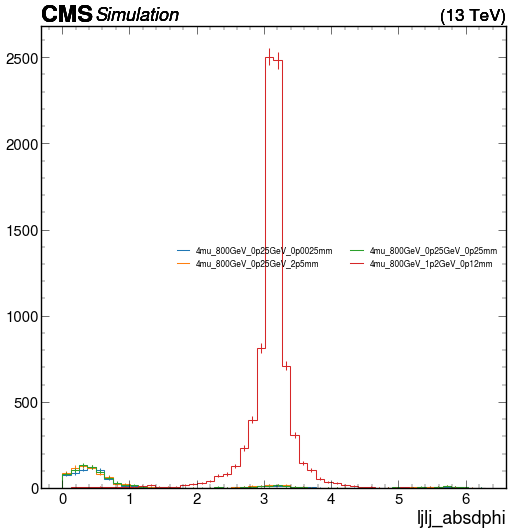

In [38]:
samples_used = [sample for sample in samples]
print(samples)
samples_used = [samples[0], samples[4], samples[2], samples[6]]
#samples_used.append("TTJets")
hists_used = ["lj_lj_absdphi"]#"lj_pfIsolation07"]
plt.subplots(1,1,figsize=(12,12))
for i in range(len(hists_used)):
    plt.subplot(1,1,i+1)
    for sample in samples_used:
        utilities.plot(out[sample]["hists"][hists_used[i]]["llpnano", :], density=False, flow='none')
    plt.legend(samples_used, prop={'size': 12}, ncol=2)
    
#plotHists(["lj_n", "lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "baseNoLj", True, True, samples_used)